# Introduction to Deep Learning Training 1.2
## MNIST Deep dive

In this notebook we will deep dive on how a CNN works using a classical dataset in DL: MNIST (remember the handwritten digit classifier from Yann LeCun in 1998: [LeNet 5](http://yann.lecun.com/exdb/lenet/))?

Sidenote: **You won't need any GPU for this notebook, you can keep just a CPU it will be fine ;)**

### About The Data

In this lesson, we will be working with ***MNIST***, a classic data set of hand-written digits.  Solutions to this problem are for instance used by banks to automatically recognize the amounts on checks, and by the postal service to automatically recognize zip codes on mail.

A image can be represented by a matrix, by creating a grid where each entry corresponds to a different pixel.

<img src="https://s15.postimg.cc/9c81y146z/digit.gif" alt="digit" style="width: 55%"/>
  
(Source of image: [Adam Geitgey](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721) )

In this case we are using black & white images, so you have enough with one number per pixel to specify the color. However if you are working with color images, the principle is the same, except that you have 3 numbers per pixel: RGB = Red Green Blue => 3 input channels, but it works in the same way.

## Imports and data

We will be using the fastai library, in which we can find the data as well.

In [1]:
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. So let's download a sample of MNIST that contains images of just these digits:

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

In [3]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [4]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files):

In [5]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [6]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Here we are using the `Image` class from the *Python Imaging Library* (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [7]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

The `4:10` indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns. NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image. Here's the same thing as a PyTorch tensor:

In [8]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

You can see they are nearly the same, but the big difference is that a PyTorch tensor can be speed up on a GPU

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [9]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. (This is much smaller than an image that you would get from a phone camera, which has millions of pixels, but is a convenient size for our initial learning and experiments. We will build up to bigger, full-color images soon.)

So, now you've seen what an image looks like to a computer, let's recall our goal: create a model that can recognize 3s and 7s. How might you go about getting a computer to do that?

## Stochastic Gradient Descent (SGD)

Do you remember the way that Arthur Samuel described machine learning, which we quoted in the intro?

> Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. In order to take advantage of the power of deep learning, we will first have to represent our task in the way that Arthur Samuel described it.

We could look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

```
def pr_eight(x,w): return (x*w).sum()
```
Here we are assuming that `x` is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector `w`. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

We want to find the specific values for the vector `w` that causes the result of our function to be high for those images that are actually 8s, and low for those images that are not. Searching for the best vector `w` is a way to search for the best function for recognising 8s. (Because we are not yet using a deep neural network, we are limited by what our function can actually do—we are going to fix that constraint later in this chapter.) 

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

These seven steps, illustrated below, are the key to the training of all deep learning models. That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive. It's amazing that this process can solve such complex problems. But, as you'll see, it really does!

<img alt="diagram" src="https://i.ibb.co/xggfm4k/Screenshot-2022-04-27-175251.png"/>

There are many different ways to do each of these seven steps, and we will be learning about them throughout the rest of this class. These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:

- Initialize: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
- Loss: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
- Step: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- Stop: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and `x` is a weight parameter of the function:

In [10]:
def f(x): 
    return x**2

In [11]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:25.)
  


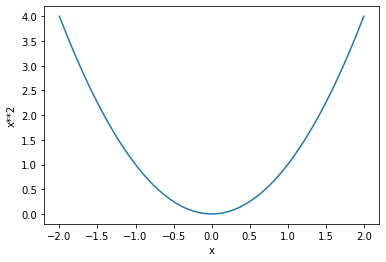

In [12]:
# Here is a graph of that function:
plot_function(f, 'x', 'x**2')

The sequence of steps we described earlier starts by picking some random value for a parameter, and calculating the value of the loss:

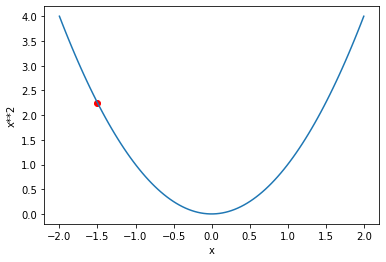

In [13]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

Now we look to see what would happen if we increased or decreased our parameter by a little bit—the *adjustment*. This is simply the slope at a particular point:

<img alt="A graph showing the squared function with the slope at one point" width="400" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/grad_illustration.svg"/>

We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, and repeat this a few times. Eventually, we will get to the lowest point on our curve:

<img alt="An illustration of gradient descent" width="400" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/chapter2_perfect.svg"/>

This basic idea goes all the way back to Isaac Newton, who pointed out that we can optimize arbitrary functions in this way. Regardless of how complicated our functions become, this basic approach of gradient descent will not significantly change. The only minor changes we will see later in this book are some handy ways we can make it faster, by finding better steps.

### Calculating Gradients
The one magic step is the bit where we calculate the gradients. As we mentioned, we use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down. In other words, the gradients will tell us how much we have to change each weight to make our model better.

You may remember from your high school calculus class that the *derivative* of a function tells you how much a change in its parameters will change its result.

The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. For instance, the derivative of the quadratic function at the value 3 tells us how rapidly the function changes at the value 3. More specifically, you may recall that gradient is defined as *rise/run*, that is, the change in the value of the function, divided by the change in the value of the parameter. When we know how our function will change, then we know what we need to do to make it smaller. This is the key to machine learning: having a way to change the parameters of a function to make it smaller. Calculus provides us with a computational shortcut, the derivative, which lets us directly calculate the gradients of our functions.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

We mentioned just now that you won't have to calculate any gradients yourself. How can that be? Amazingly enough, PyTorch is able to automatically compute the derivative of nearly any function! What's more, it does it very fast. Most of the time, it will be at least as fast as any derivative function that you can create by hand. Let's see an example.

First, let's pick a tensor value which we want gradients at:

In [14]:
xt = tensor(3.).requires_grad_()

In [15]:
xt

tensor(3., requires_grad=True)

Notice the special method `requires_grad_`? That's the magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.

> This API might throw you off if you're coming from math or physics. In those contexts the "gradient" of a function is just another function (i.e., its derivative), so you might expect gradient-related APIs to give you a new function. But in deep learning, "gradients" usually means the _value_ of a function's derivative at a particular argument value. The PyTorch API also puts the focus on the argument, not the function you're actually computing the gradients of. It may feel backwards at first, but it's just a different perspective.

Now we calculate our function with that value. Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

In [16]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Finally, we tell PyTorch to calculate the gradients for us:

In [17]:
yt.backward()

The "backward" here refers to *backpropagation*, which is the name given to the process of calculating the derivative of each layer. This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated. Life would probably be easier if `backward` was just called `calculate_grad`, but deep learning folks really do like to add jargon everywhere they can!

We can now view the gradients by checking the `grad` attribute of our tensor:

In [18]:
xt.grad

tensor(6.)

If you remember your high school calculus rules, the derivative of `x**2` is `2*x`, and we have `x=3`, so the gradients should be `2*3=6`, which is what PyTorch calculated for us!


Now we'll repeat the preceding steps, but with a vector argument for our function:

In [19]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we'll add `sum` to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

In [20]:
def f(x): 
    return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Our gradients are `2*xt`, as we'd expect!

In [21]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters. But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

### Stepping With a Learning Rate

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the *learning rate* (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you a better approach later, called the *learning rate finder*). Once you've picked a learning rate, you can adjust your parameters using this simple function:

```
w -= gradient(w) * lr
```

This is known as *stepping* your parameters, using an *optimizer step*. Notice how we _subtract_ the `gradient * lr` from the parameter to update it.  This allows us to adjust the parameter in the direction of the slope by increasing the parameter when the slope is negative and decreasing the parameter when the slope is positive.  We want to adjust our parameters in the direction of the slope because our goal in deep learning is to _minimize_ the loss.

If you pick a learning rate that's too low, it can mean having to do a lot of steps. The figure below illustrates that.

<img alt="An illustration of gradient descent with a LR too low" width="400" caption="Gradient descent with low LR" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/chapter2_small.svg" id="descent_small"/>

But picking a learning rate that's too high is even worse—it can actually result in the loss getting *worse*, as we see below

<img alt="An illustration of gradient descent with a LR too high" width="400" caption="Gradient descent with high LR" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/chapter2_div.svg" id="descent_div"/>

If the learning rate is too high, it may also "bounce" around, rather than actually diverging; The image below shows how this has the result of taking many steps to train successfully.

<img alt="An illustation of gradient descent with a bouncy LR" width="400" caption="Gradient descent with bouncy LR" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/chapter2_bouncy.svg" id="descent_bouncy"/>

Now let's apply all of this in an end-to-end example.

### An End-to-End SGD Example

We've seen how to use gradients to find a minimum. Now it's time to look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

In [22]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

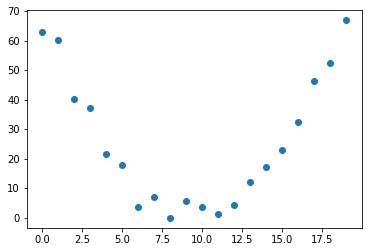

In [23]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

We've added a bit of random noise, since measuring things manually isn't precise. This means it's not that easy to answer the question: what was the roller coaster's speed? Using SGD we can try to find a function that matches our observations. We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., a function of the form `a*(time**2)+(b*time)+c`.

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define *which* quadratic we're trying). So, let's collect the parameters in one argument and thus separate the input, `t`, and the parameters, `params`, in the function's signature: 

In [24]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In other words, we've restricted the problem of finding the best imaginable function that fits the data, to finding the best *quadratic* function. This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters `a`, `b`, and `c`. Thus, to find the best quadratic function, we only need to find the best values for `a`, `b`, and `c`.

If we can solve this problem for the three parameters of a quadratic function, we'll be able to apply the same approach for other, more complex functions with more parameters—such as a neural net. Let's find the parameters for `f` first, and then we'll come back and do the same thing for the MNIST dataset with a neural net.

We need to define first what we mean by "best." We define this precisely by choosing a *loss function*, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. It is important for loss functions to return _lower_ values when predictions are more accurate, as the SGD procedure we defined earlier will try to _minimize_ this loss. For continuous data, it's common to use *mean squared error*:

In [25]:
def mse(preds, targets): 
    return ((preds-targets)**2).mean()

Now, let's work through our 7 step process.

#### Step 1: Initialize the parameters

First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using `requires_grad_`:

In [26]:
params = torch.randn(3).requires_grad_()

In [27]:
# saving the params to make a plot later, you can ignore this
orig_params = params.clone()

#### Step 2: Calculate the predictions
Next, we calculate the predictions:

In [28]:
preds = f(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

In [29]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

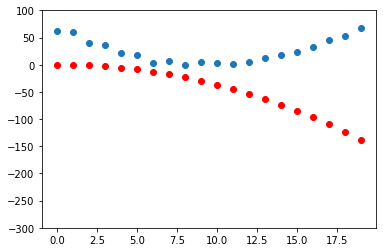

In [30]:
show_preds(preds)

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

#### Step 3: Calculate the loss
We calculate the loss as follows:

In [31]:
loss = mse(preds, speed)
loss

tensor(8080.6499, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we'll need to know the gradients.
#### Step 4: Calculate the gradients
The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

In [32]:
loss.backward()
params.grad

tensor([-28968.5938,  -1852.4731,   -144.0905])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

In [33]:
params.grad * 1e-5

tensor([-0.2897, -0.0185, -0.0014])

In [34]:
params

tensor([-0.3989,  0.3281, -0.1130], requires_grad=True)

#### Step 5: Step the weights.

Now we need to update the parameters based on the gradients we just calculated:


In [35]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

So now we compute the new parameters as the actual parameters minus the learning rate times the gradient. Here we added a special part: `.data`, which if you use it the gradient is not calculated. We don't want to calculate the gradient of the actual step that we do, we only want to compute it on the function `f`. After that delete the gradients that we already have (to be able to compute new for the next step).

Understanding this bit depends on remembering recent history. To calculate the gradients we call `backward` on the `loss`. But this `loss` was itself calculated by `mse`, which in turn took `preds` as an input, which was calculated using `f` taking as an input `params`, which was the object on which we originally called `required_grads_`—which is the original call that now allows us to call `backward` on `loss`. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

Let's see if the loss has improved:

In [36]:
preds = f(time,params)
mse(preds, speed)

tensor(2034.7380, grad_fn=<MeanBackward0>)

And take a look at the plot:

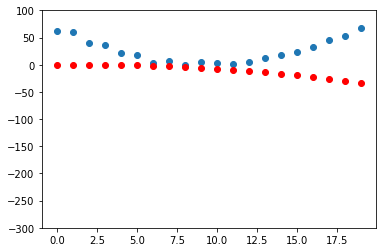

In [37]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step:

In [38]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

Now we iterate. By looping and performing many improvements, we hope to reach a good result:

In [39]:
for i in range(10): apply_step(params)

2034.738037109375
890.6641845703125
674.1678466796875
633.1974487304688
625.4419555664062
623.9716796875
623.6907958984375
623.6350708007812
623.621826171875
623.6165771484375


In [40]:
params = orig_params.detach().requires_grad_()

The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

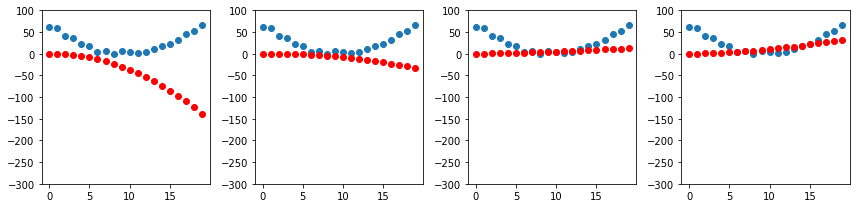

In [41]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop
We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

### Summarizing Gradient Descent
To summarize, at the beginning, the weights of our model can be random (training *from scratch*) or come from a pretrained model (*transfer learning*). In the first case, the output we will get from our inputs won't have anything to do with what we want, and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting. So the model will need to *learn* better weights.

We begin by comparing the outputs the model gives us with our targets (we have labeled data, so we know what result the model should give) using a *loss function*, which returns a number that we want to make as low as possible by improving our weights. To do this, we take a few data items (such as images) from the training set and feed them to our model. We compare the corresponding targets using our loss function, and the score we get tells us how wrong our predictions were. We then change the weights a little bit to make it slightly better.

To find how to change the weights to make the loss a bit better, we use calculus to calculate the *gradients*. (Actually, we let PyTorch do it for us!) Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the *learning rate* to decide on the step size. We then *iterate* until we have reached the lowest point, which will be our parking lot, then we can *stop*.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function. Let's now see how we can define a good training objective. 

## The MNIST Loss Function

We already have our independent variables `x`—these are the images themselves. We first need to tranform them into tensors and stack them to be able to perform computations on them all together. To do this we first combine all the images in this list into a single three-dimensional tensor. We already know how to create a tensor containing a single image. To create a tensor containing all the images in a directory, we will first use a Python list comprehension to create a plain list of the single image tensors.

In [42]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

The most common way to describe such a tensor is to call it a *rank-3 tensor*. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called `stack` that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [43]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Perhaps the most important attribute of a tensor is its *shape*. This tells you the length of each axis. In this case, we can see that we have 6,131 images, each of size 28×28 pixels. There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

The *length* of a tensor's shape is its rank:

In [44]:
len(stacked_threes.shape)

3

We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using `view`, which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data" (i.e. to be able to fit all the rows):

In [45]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need a label for each image. We'll use `1` for 3s and `0` for 7s. We add the `unsqueeze` bit here as it needs a matrix in pytorch, and the unsqueeze is just going to add an additional unit dimension at the position asked to make it from a vector to a matrix with 1 column:

In [46]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [47]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [48]:
# do the same on the validation set
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [49]:
# do the same on the validation set
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an (initially random) weight for every pixel (this is the *initialize* step in our seven-step process):

In [50]:
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
weights[:5]

tensor([[-0.2453],
        [ 0.7839],
        [-2.1785],
        [ 0.0784],
        [ 0.2277]], grad_fn=<SliceBackward>)

The function `weights*pixels` won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its *intercept* is 0). You might remember from high school math that the formula for a line is `y=w*x+b`; we still need the `b`. We'll initialize it to a random number too:

In [51]:
bias = init_params(1)
bias

tensor([0.0298], requires_grad=True)

In neural networks, the `w` in the equation `y=w*x+b` is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

We can now calculate a prediction for one image:

In [52]:
(train_x[0]*weights.T).sum() + bias

tensor([17.4497], grad_fn=<AddBackward0>)

While we could use a Python `for` loop to calculate the prediction for each image, that would be very slow. Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.

In this case, there's an extremely convenient mathematical operation that calculates `w*x` for every row of a matrix—it's called *matrix multiplication*. The image below shows what matrix multiplication looks like.
    
<img alt="Matrix multiplication" width="400" caption="Matrix multiplication" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/matmul2.svg" id="matmul"/>

This image shows two matrices, `A` and `B`, being multiplied together. Each item of the result, which we'll call `AB`, contains each item of its corresponding row of `A` multiplied by each item of its corresponding column of `B`, added together. For instance, row 1, column 2 (the orange dot with a red border) is calculated as $a_{1,1} * b_{1,2} + a_{1,2} * b_{2,2}$. If you need a refresher on matrix multiplication, we suggest you take a look at the [Intro to Matrix Multiplication](https://youtu.be/kT4Mp9EdVqs) on *Khan Academy* or look at this [visual illustration](http://matrixmultiplication.xyz/), since this is the most important mathematical operation in deep learning.

In Python, matrix multiplication is represented with the `@` operator. Let's try it:

In [53]:
def linear1(xb): 
    return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[17.4497],
        [21.5071],
        [18.2835],
        ...,
        [10.3764],
        [14.7433],
        [ 9.2027]], grad_fn=<AddBackward0>)

The first element is the same as we calculated before, as we'd expect. This equation, `batch@weights + bias`, is one of the two fundamental equations of any neural network (the other one is the *activation function*, which we'll see in a moment).

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.5, so our accuracy for each item can be calculated.
#### Broadcasting
This can be calculated using broadcasting, instead of loops! The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use *broadcasting*. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.

After broadcasting so the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank: it performs the operation on each corresponding element of the two tensors, and returns the tensor result. For instance:

In [54]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

In our case we want to compare our prediction with `0.5`. To decide if an output represents a 3 or a 7, we can just check whether it's greater than `0.5`, so our accuracy for each item can be calculated.

In [55]:
corrects = (preds>0.5).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [56]:
# check our accuracy
corrects.float().mean().item()

0.4947563707828522

Now let's see what the change in accuracy is for a small change in one of the weights:

In [57]:
weights.data[0] *= 1.0001

In [58]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4945143461227417

As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some *loss function* that represents how good our model is. That is because the gradients are a measure of how that loss function changes with small tweaks to the weights.

So, we need to choose a loss function. The obvious approach would be to use accuracy, which is our metric, as our loss function as well. In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.

Unfortunately, we have a significant technical problem here. The gradient of a function is its *slope*, or its steepness, which can be defined as *rise over run*—that is, how much the value of the function goes up or down, divided by how much we changed the input. We can write this in mathematically as: `(y_new - y_old) / (x_new - x_old)`. This gives us a good approximation of the gradient when `x_new` is very similar to `x_old`, meaning that their difference is very small. But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa. The problem is that a small change in weights from `x_old` to `x_new` isn't likely to cause any prediction to change, so `(y_new - y_old)` will almost always be 0. In other words, the gradient is 0 almost everywhere.

A very small change in the value of a weight will often not actually change the accuracy at all. This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number.

> In mathematical terms, accuracy is a function that is constant almost everywhere (except at the threshold, 0.5), so its derivative is nil almost everywhere (and infinity at the threshold). This then gives gradients that are 0 or infinite, which are useless for updating the model.

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

Let's write such a function now. What form does it take?

The loss function receives not the images themselves, but the predictions from the model. Let's make one argument, `prds`, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another argument, `trgts`, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

So, for instance, suppose we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence (`0.9`) that the first was a 3, with slight confidence (`0.4`) that the second was a 7, and with fair confidence (`0.2`), but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

In [59]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Here's a first try at a loss function that measures the distance between `predictions` and `targets`:

In [60]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

We're using a new function, `torch.where(a,b,c)`. This is the same as running the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`, except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

> It's important to learn about PyTorch functions like this, because looping over tensors in Python performs at Python speed, not C/CUDA speed! Try running `help(torch.where)` now to read the docs for this function, or, better still, look it up on the PyTorch documentation site.

In [61]:
help(torch.where)

Help on built-in function where:

where(...)
    where(condition, x, y) -> Tensor
    
    Return a tensor of elements selected from either :attr:`x` or :attr:`y`, depending on :attr:`condition`.
    
    The operation is defined as:
    
    .. math::
        \text{out}_i = \begin{cases}
            \text{x}_i & \text{if } \text{condition}_i \\
            \text{y}_i & \text{otherwise} \\
        \end{cases}
    
    .. note::
        The tensors :attr:`condition`, :attr:`x`, :attr:`y` must be :ref:`broadcastable <broadcasting-semantics>`.
    
    .. note::
        Currently valid scalar and tensor combination are
        1. Scalar of floating dtype and torch.double
        2. Scalar of integral dtype and torch.long
        3. Scalar of complex dtype and torch.complex128
    
    Arguments:
        condition (BoolTensor): When True (nonzero), yield x, otherwise yield y
        x (Tensor or Scalar): value (if :attr:x is a scalar) or values selected at indices
                         

Let's try it on our `prds` and `trgts`:

In [62]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

You can see that this function returns a lower number when predictions are more accurate, when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. In PyTorch, we always assume that a lower value of a loss function is better. Since we need a scalar for the final loss, `mnist_loss` takes the mean of the previous tensor:

In [63]:
mnist_loss(prds,trgts)

tensor(0.4333)

For instance, if we change our prediction for the one "false" target from `0.2` to `0.8` the loss will go down, indicating that this is a better prediction:

In [64]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.

### Sigmoid

The `sigmoid` function always outputs a number between 0 and 1. It's defined as follows:

In [65]:
def sigmoid(x): 
    return 1/(1+torch.exp(-x))

Pytorch defines an accelerated version for us, so we don’t really need our own. This is an important function in deep learning, since we often want to ensure values are between 0 and 1. This is what it looks like:

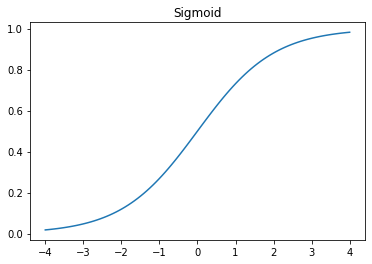

In [66]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients. 

Let's update `mnist_loss` to first apply `sigmoid` to the inputs:

In [67]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. All that is required is that a higher prediction corresponds to higher confidence an image is a 3.

Having defined a loss function, now is a good moment to recapitulate why we did this. After all, we already had a metric, which was overall accuracy. So why did we define a loss?

The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal, and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics, on the other hand, are the numbers that we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

### SGD and Mini-Batches

Now that we have a loss function that is suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on the gradients. This is called an *optimization step*.

In order to take an optimization step we need to calculate the loss over one or more data items. How many should we use? We could calculate it for the whole dataset, and take the average, or we could calculate it for a single data item. But neither of these is ideal. Calculating it for the whole dataset would take a very long time. Calculating it for a single item would not use much information, so it would result in a very imprecise and unstable gradient. That is, you'd be going to the trouble of updating the weights, but taking into account only how that would improve the model's performance on that single item.

So instead we take a compromise between the two: we calculate the average loss for a few data items at a time. This is called a *mini-batch*. The number of data items in the mini-batch is called the *batch size*. A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately. We will talk about how to make this choice throughout this book.

Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU. These accelerators only perform well if they have lots of work to do at a time, so it's helpful if we can give them lots of data items to work on. Using mini-batches is one of the best ways to do this. However, if you give them too much data to work on at once, they run out of memory—making GPUs happy is also tricky!

As we will see in the next lesson in our discussion of data augmentation, we get better generalization if we can vary things during training. One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader`.

A `DataLoader` can take any Python collection and turn it into an iterator over many batches, like so:

In [68]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 5,  8,  3,  2, 13]),
 tensor([10, 14,  0,  6,  7]),
 tensor([ 1,  9, 11, 12,  4])]

For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`. Here's an example of an extremely simple `Dataset`:

In [69]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a `Dataset` to a `DataLoader` we will get back many batches which are themselves tuples of tensors representing batches of independent and dependent variables:

In [70]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([15, 19, 13,  2,  3,  4]), ('p', 't', 'n', 'c', 'd', 'e')),
 (tensor([18,  0,  1, 14,  9, 10]), ('s', 'a', 'b', 'o', 'j', 'k')),
 (tensor([25,  6, 21, 23, 24, 12]), ('z', 'g', 'v', 'x', 'y', 'm')),
 (tensor([16,  7, 11, 22, 17,  8]), ('q', 'h', 'l', 'w', 'r', 'i')),
 (tensor([ 5, 20]), ('f', 'u'))]

We are now ready to write our first training loop for a model using SGD!

## Putting It All Together

It's time to implement the process we saw in SGD. In code, our process will be implemented something like this for each epoch:

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```
First, let's re-initialize our parameters:

In [71]:
weights = init_params((28*28,1))
bias = init_params(1)

A `DataLoader` can be created from a `Dataset`:

In [72]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the validation set:

In [73]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Let's create a mini-batch of size 4 for testing:

In [74]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [75]:
preds = linear1(batch)
preds

tensor([[ 1.1149],
        [ 2.9111],
        [ 4.5749],
        [-0.0058]], grad_fn=<AddBackward0>)

In [76]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.2026, grad_fn=<MeanBackward0>)

Now we can calculate the gradients:

In [77]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0197), tensor([-0.1238]))

The gradients are 784 by 1, so a column where every row is the gradient of the weight and the bias gradient is just a single number.

Let's put that all in a function:

In [78]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

and test it:

In [79]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0395), tensor([-0.2475]))

But look what happens if we call it twice:

In [80]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0592), tensor([-0.3713]))

The gradients have changed! The reason for this is that `loss.backward` actually *adds* the gradients of `loss` to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [81]:
weights.grad.zero_()
bias.grad.zero_();

> note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects _in place_. For instance, `bias.zero_()` sets all elements of the tensor `bias` to 0.

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [82]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated with:

In [83]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [ True],
        [False]])

That gives us this function to calculate our validation accuracy:

In [84]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

We can check it works:

In [85]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.7500)

and then put the batches together (i.e. compute the accuracy on all our batches in the validation set):

In [86]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [87]:
validate_epoch(linear1)

0.6734

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

In [88]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7103

Then do a few more:

In [89]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8588 0.9086 0.928 0.9378 0.9461 0.9505 0.9535 0.9564 0.9608 0.9622 0.9632 0.9632 0.9637 0.9637 0.9642 0.9647 0.9666 0.9661 0.9666 0.9671 

Looking good! We're already at a good accuracy, and we've created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an *optimizer*.

### Creating an Optimizer

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our `linear1` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate our model from the previous section:

In [90]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

In [91]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [92]:
class BasicOptim:
    def __init__(self,params,lr): 
        self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: 
            p.grad = None

We can create our optimizer by passing in the model's parameters:

In [93]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

In [94]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Our validation function doesn't need to change at all:

In [95]:
validate_epoch(linear_model)

0.6284

Let's put our little training loop in a function, to make things simpler:

In [96]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

The results are the same as in the previous section:

In [97]:
train_model(linear_model, 20)

0.4932 0.8598 0.833 0.9121 0.9336 0.9472 0.956 0.9623 0.9658 0.9672 0.9687 0.9702 0.9731 0.9745 0.976 0.9765 0.9775 0.9775 0.978 0.9785 

fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:

In [98]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8842 0.8173 0.9062 0.9316 0.9453 0.955 0.9623 0.9653 0.9667 0.9687 0.9706 0.9731 0.9745 0.9755 0.9765 0.9775 0.9775 0.9785 0.9785 

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:

In [99]:
dls = DataLoaders(dl, valid_dl)

To create a `Learner` without using an application (such as `cnn_learner`) we need to pass in all the elements that we've created in this chapter: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [100]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call `fit`:

In [101]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636957,0.503431,0.495584,00:00
1,0.505036,0.199496,0.827772,00:00
2,0.185953,0.170363,0.849362,00:00
3,0.081666,0.103173,0.914622,00:00
4,0.043332,0.076159,0.933759,00:00
5,0.028395,0.061357,0.947988,00:00
6,0.022266,0.052078,0.955348,00:00
7,0.019545,0.045869,0.961727,00:00
8,0.018169,0.041481,0.965653,00:00
9,0.017347,0.038234,0.967615,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future lessons.)

With these classes, we can now replace our linear model with a neural network.

## Adding a Nonlinearity

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [102]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.

Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; that is, parameters that are initially randomly initialized, just like we did in the previous section:

In [103]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.

That little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*. We think we can all agree that *rectified linear unit* sounds pretty fancy and complicated... But actually, there's nothing more to it than `res.max(tensor(0.0))`—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as `F.relu`:

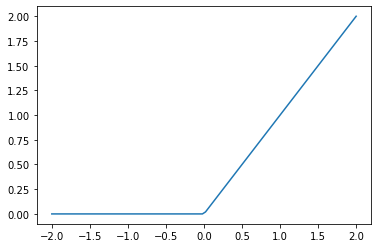

In [104]:
plot_function(F.relu)

> There is an enormous amount of jargon in deep learning, including terms like _rectified linear unit_. The vast vast majority of this jargon is no more complicated than can be implemented in a short line of code, as we saw in this example. The reality is that for academics to get their papers published they need to make them sound as impressive and sophisticated as possible. One of the ways that they do that is to introduce jargon. Unfortunately, this has the result that the field ends up becoming far more intimidating and difficult to get into than it should be. You do have to learn the jargon, because otherwise papers and tutorials are not going to mean much to you. But that doesn't mean you have to find the jargon intimidating. Just remember, when you come across a word or phrase that you haven't seen before, it will almost certainly turn out to be referring to a very simple concept.

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

But if we put a nonlinear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The `max` function is particularly interesting, because it operates as a simple `if` statement.

> Mathematically, we say the composition of two linear functions is another linear function. So, we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the *universal approximation theorem*. The three lines of code that we have here are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [105]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.

In [106]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [107]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.339404,0.401294,0.506869,00:00
1,0.156504,0.236980,0.793425,00:00
2,0.085476,0.117934,0.910206,00:00
3,0.055229,0.078914,0.940628,00:00
4,0.041290,0.061361,0.956330,00:00
5,0.034248,0.051602,0.962218,00:00
6,0.030264,0.045479,0.964671,00:00
7,0.027715,0.041309,0.967615,00:00
8,0.025898,0.038284,0.968597,00:00
9,0.024500,0.035977,0.970069,00:00


the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

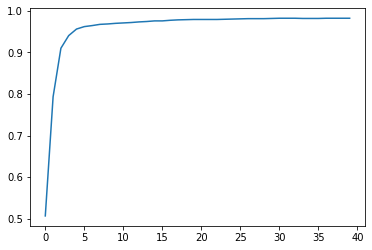

In [108]:
plt.plot(L(learn.recorder.values).itemgot(2));

And we can view the final accuracy:

In [109]:
learn.recorder.values[-1][2]

0.98233562707901

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)

This is why deep learning can do things which seem rather magical, such fantastic things. Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.

# Excercises

Retry to do the "An End-to-End SGD Example" but using a smaller and a bigger learning rate and see what happens